In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from xml.dom import minidom

import umap
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_extraction.text import TfidfTransformer

import torch
import torch.nn.functional as F
from contrastive_loss_pytorch import ContrastiveLoss

from sklearn.metrics import mean_absolute_error
from scipy import stats
from scipy.spatial.distance import cdist
import pickle
import tqdm

## Loading Test data for model testing

In [3]:
cancer_mrna_tr = np.load('./bc_data/bc_cancer_mrna_tr.npy')
hc_mrna_tr = np.load('./bc_data/bc_hc_mrna_tr.npy')

cancer_mrna_ts = np.load('./bc_data/bc_cancer_mrna_ts.npy')
hc_mrna_ts = np.load('./bc_data/bc_hc_mrna_ts.npy')

cancer_exrna_tr = np.load('./bc_data/bc_cancer_exrna_tr.npy')
hc_exrna_tr = np.load('./bc_data/bc_hc_exrna_tr.npy')

cancer_exrna_ts = np.load('./bc_data/bc_cancer_exrna_ts.npy')
hc_exrna_ts = np.load('./bc_data/bc_hc_exrna_ts.npy')

## Baseline model (exRNA to mRNA)

In [4]:
# Creating a PyTorch class
class AE(torch.nn.Module):
	def __init__(self,input_dim=cancer_exrna_ts.shape[1], output_dim=cancer_mrna_ts.shape[1]):
		super().__init__()
		# Building a linear encoder with Linear
		# layer followed by Relu activation function
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(input_dim, 512),
			torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
			torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
		)
		
		# Building an linear decoder with Linear
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
			torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
			torch.nn.Linear(512, output_dim),
			torch.nn.Sigmoid()
		)
	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [5]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)


In [6]:
checkpoint = torch.load('./models/bc_compare_extom.pt',map_location=torch.device('cpu'))
model = AE(input_dim=cancer_exrna_ts.shape[1], output_dim=cancer_mrna_ts.shape[1])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


AE(
  (encoder): Sequential(
    (0): Linear(in_features=2438, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=36, bias=True)
    (9): ReLU()
    (10): Linear(in_features=36, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=1883, bias=True)
    (11): Sigmoid()
  )
)

In [7]:
##4. Integration visualization - test
model.eval()
with torch.no_grad():
    model.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    cex_encoder_ts = model.encoder(X_all_tensor_cex_ts)
    cm_decoder = model.decoder(cex_encoder_ts)
    b_pred_cm_ts = torch.Tensor.cpu(cm_decoder).detach().numpy()

    hex_encoder_ts = model.encoder(X_all_tensor_hex_ts)
    hm_decoder = model.decoder(hex_encoder_ts)
    b_pred_hm_ts = torch.Tensor.cpu(hm_decoder).detach().numpy()


In [8]:
# Unpaired metric
print("\n\n########## Baseline model (exRNA to mRNA) ##########\n")

print(stats.pearsonr(np.mean(b_pred_cm_ts,axis=0),np.mean(cancer_mrna_ts,axis=0)))
print(stats.pearsonr(np.mean(b_pred_hm_ts,axis=0),np.mean(hc_mrna_ts,axis=0)))
print(stats.pearsonr(np.mean(np.concatenate([b_pred_cm_ts,b_pred_hm_ts]),axis=0),
                     np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))

#Unpaired Spearman
print(stats.spearmanr(np.mean(b_pred_cm_ts,axis=0),np.mean(cancer_mrna_ts,axis=0)))
print(stats.spearmanr(np.mean(b_pred_hm_ts,axis=0),np.mean(hc_mrna_ts,axis=0)))
print(stats.spearmanr(np.mean(np.concatenate([b_pred_cm_ts,b_pred_hm_ts]),axis=0),
                     np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))

#Unpaired MAE
from sklearn.metrics import mean_absolute_error

pred_extom = np.concatenate([b_pred_cm_ts,b_pred_hm_ts])
true_extom = np.concatenate([cancer_mrna_ts,hc_mrna_ts])

print("MAE Cancer mRNA: ",mean_absolute_error(np.mean(b_pred_cm_ts,axis=0), np.mean(cancer_mrna_ts,axis=0)))
print("MAE Healthy mRNA: ",mean_absolute_error(np.mean(b_pred_hm_ts,axis=0),np.mean(hc_mrna_ts,axis=0)))
print("MAE mRNA: ",mean_absolute_error(np.mean(pred_extom,axis=0),
                     np.mean(true_extom,axis=0)))

print("\n\n\n")



########## Baseline model (exRNA to mRNA) ##########

PearsonRResult(statistic=0.24232320452564393, pvalue=1.442113851848284e-26)
PearsonRResult(statistic=0.2020909220946093, pvalue=8.358131102894069e-19)
PearsonRResult(statistic=0.2354697963869613, pvalue=3.88772286145376e-25)
SignificanceResult(statistic=0.943423512590305, pvalue=0.0)
SignificanceResult(statistic=0.9931050990961147, pvalue=0.0)
SignificanceResult(statistic=0.9971376235024235, pvalue=0.0)
MAE Cancer mRNA:  2.2328617219120726
MAE Healthy mRNA:  8.668970880614749
MAE mRNA:  5.3206601279299655






## Baseline Model (mRNA to exRNA)

In [9]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE_mtoex(torch.nn.Module):
	def __init__(self,input_dim=cancer_mrna_ts.shape[1], output_dim=cancer_exrna_ts.shape[1]):
		super().__init__()
		# Building a linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(input_dim, 512),
			torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
			torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
# 			torch.nn.ReLU(),
# 			torch.nn.Linear(18, 9)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
# 			torch.nn.Linear(9, 18),
# 			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
			torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
			torch.nn.Linear(512, output_dim),
			torch.nn.Sigmoid()
		)
	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [10]:
# Model Initialization
model_mtoex = AE_mtoex()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model_mtoex.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)


In [12]:
checkpoint = torch.load('./models/bc_compare_mtoex.pt',map_location=torch.device('cpu'))
model_mtoex = AE_mtoex(input_dim=cancer_mrna_ts.shape[1], output_dim=cancer_exrna_ts.shape[1])
model_mtoex.load_state_dict(checkpoint['model_state_dict'])
model_mtoex.eval()


AE_mtoex(
  (encoder): Sequential(
    (0): Linear(in_features=1883, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=36, bias=True)
    (9): ReLU()
    (10): Linear(in_features=36, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=2438, bias=True)
    (11): Sigmoid()
  )
)

In [13]:
##4. Integration visualization - test
model_mtoex.eval()
with torch.no_grad():
    model_mtoex.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    cm_encoder_ts = model_mtoex.encoder(X_all_tensor_cm_ts)
    cex_decoder = model_mtoex.decoder(cm_encoder_ts)
    b_pred_cex_ts = torch.Tensor.cpu(cex_decoder).detach().numpy()

    hm_encoder_ts = model_mtoex.encoder(X_all_tensor_hm_ts)
    hex_decoder = model_mtoex.decoder(hm_encoder_ts)
    b_pred_hex_ts = torch.Tensor.cpu(hex_decoder).detach().numpy()

In [14]:
#Unpaired Pearsonr
print("\n\n########## Baseline model (mRNA to exRNA) ##########\n")

print(stats.pearsonr(np.mean(b_pred_cex_ts,axis=0),np.mean(cancer_exrna_ts,axis=0)))
print(stats.pearsonr(np.mean(b_pred_hex_ts,axis=0),np.mean(hc_exrna_ts,axis=0)))
print(stats.pearsonr(np.mean(np.concatenate([b_pred_cex_ts,b_pred_hex_ts]),axis=0),
                     np.mean(np.concatenate([cancer_exrna_ts,hc_exrna_ts]),axis=0)))

#Unpaired Spearman
print(stats.spearmanr(np.mean(b_pred_cex_ts,axis=0),np.mean(cancer_exrna_ts,axis=0)))
print(stats.spearmanr(np.mean(b_pred_hex_ts,axis=0),np.mean(hc_exrna_ts,axis=0)))
print(stats.spearmanr(np.mean(np.concatenate([b_pred_cex_ts,b_pred_hex_ts]),axis=0),
                     np.mean(np.concatenate([cancer_exrna_ts,hc_exrna_ts]),axis=0)))

pred_mtoex = np.concatenate([b_pred_cex_ts,b_pred_hex_ts])
true_mtoex = np.concatenate([cancer_exrna_ts,hc_exrna_ts])

#Unpaired MAE
from sklearn.metrics import mean_absolute_error

print("MAE Cancer exRNA: ",mean_absolute_error(np.mean(b_pred_cex_ts,axis=0), np.mean(cancer_exrna_ts,axis=0)))
print("MAE Healthy exRNA: ",mean_absolute_error(np.mean(b_pred_hex_ts,axis=0),np.mean(hc_exrna_ts,axis=0)))
print("MAE exRNA: ",mean_absolute_error(np.mean(pred_mtoex,axis=0),
                     np.mean(true_mtoex,axis=0)))

print("\n\n\n")



########## Baseline model (exRNA to mRNA) ##########

PearsonRResult(statistic=0.031173005450682672, pvalue=0.1238564847227321)
PearsonRResult(statistic=-0.001726708225118804, pvalue=0.9320908861216403)
PearsonRResult(statistic=0.014184246845797248, pvalue=0.4839029860120945)
SignificanceResult(statistic=0.8795398436081922, pvalue=0.0)
SignificanceResult(statistic=0.6262344605704631, pvalue=1.1442701336878384e-265)
SignificanceResult(statistic=0.7956848825796431, pvalue=0.0)
MAE Cancer exRNA:  14.692505521702675
MAE Healthy exRNA:  41.9388879935632
MAE exRNA:  28.315668214312844






## Encoder Model-CrossPred

In [15]:
class CrossPred(torch.nn.Module):
    def __init__(self,input_dim_a=2000,input_dim_b=2000,emb_dim=128):
        super(CrossPred, self).__init__()
        self.input_dim_a = input_dim_a
        self.input_dim_b = input_dim_b
#         self.clf_out = clf_out
        self.encoder_a = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_a, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        self.encoder_b = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_b, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        
    def forward(self, x_a,x_b):
        out_a = self.encoder_a(x_a)
        
        out_b = self.encoder_b(x_b)
        return out_a,out_b

In [17]:
checkpoint = torch.load('./models/bc_crosspred.pt',map_location=torch.device('cpu'))
net = CrossPred(input_dim_a=cancer_mrna_ts.shape[1],input_dim_b=cancer_exrna_ts.shape[1])
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

CrossPred(
  (encoder_a): Sequential(
    (0): Linear(in_features=1883, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_b): Sequential(
    (0): Linear(in_features=2438, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [18]:
##4. Integration visualization - train
net.eval()
with torch.no_grad():
    net.to(torch.device("cpu"))

    # X_all_tensor_cm = torch.tensor(norm_c_mrna).float()
    # X_all_tensor_hm = torch.tensor(norm_hc_mrna).float()

    # X_all_tensor_cex = torch.tensor(norm_c_exrna).float()
    # X_all_tensor_hex = torch.tensor(norm_hc_exrna).float()

    X_all_tensor_cm = torch.tensor(cancer_mrna_tr).float()
    X_all_tensor_hm = torch.tensor(hc_mrna_tr).float()

    X_all_tensor_cex = torch.tensor(cancer_exrna_tr).float()
    X_all_tensor_hex = torch.tensor(hc_exrna_tr).float()

    y_pred_cm = net.encoder_a(X_all_tensor_cm)
#     y_pred_cm = net.feature(y_pred_cm)
    # y_pred_cm = F.normalize(y_pred_cm, dim=1,p=2)
    y_pred_cm = torch.Tensor.cpu(y_pred_cm).detach().numpy()

    y_pred_hm = net.encoder_a(X_all_tensor_hm)
#     y_pred_hm = net.feature(y_pred_hm)
    # y_pred_hm = F.normalize(y_pred_hm, dim=1,p=2)
    y_pred_hm = torch.Tensor.cpu(y_pred_hm).detach().numpy()

    y_pred_cex = net.encoder_b(X_all_tensor_cex)
#     y_pred_cex = net.feature(y_pred_cex)
    # y_pred_cex = F.normalize(y_pred_cex, dim=1,p=2)
    y_pred_cex = torch.Tensor.cpu(y_pred_cex).detach().numpy()

    y_pred_hex = net.encoder_b(X_all_tensor_hex)
#     y_pred_hex = net.feature(y_pred_hex)
    # y_pred_hex = F.normalize(y_pred_hex, dim=1,p=2)
    y_pred_hex = torch.Tensor.cpu(y_pred_hex).detach().numpy()

y_pred = np.concatenate((y_pred_cm, y_pred_hm, y_pred_cex, y_pred_hex),axis=0)
umaps = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=2,
                  metric="cosine").fit(y_pred)##we use UMAP to visualize the integrated representation

embedding = umaps.transform(y_pred)

In [19]:
color_h_c = np.concatenate(([0]*len(y_pred_cm), [1]*len(y_pred_hm), [0]*len(y_pred_cex), [1]*len(y_pred_hex)))
color_m_ex = np.concatenate(([0]*len(y_pred_cm), [0]*len(y_pred_hm), [1]*len(y_pred_cex), [1]*len(y_pred_hex)))

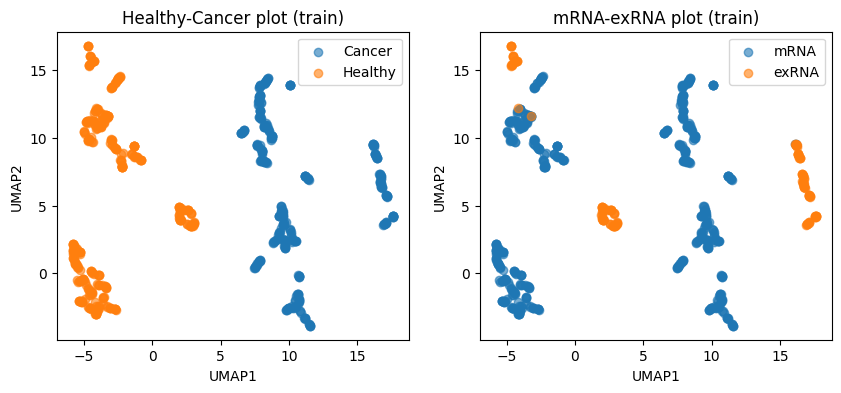

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(121)

iddx = np.where(color_h_c == 0)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='Cancer')

iddx = np.where(color_h_c == 1)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='Healthy')

plt.title('Healthy-Cancer plot (train)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()

plt.subplot(122)
iddx = np.where(color_m_ex == 0)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='mRNA')

iddx = np.where(color_m_ex == 1)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='exRNA')

plt.title('mRNA-exRNA plot (train)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()

In [21]:
##4. Integration visualization - test
net.eval()
with torch.no_grad():
    net.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    y_pred_cm_ts = net.encoder_a(X_all_tensor_cm_ts)
    y_pred_cm_ts = torch.Tensor.cpu(y_pred_cm_ts).detach().numpy()

    y_pred_hm_ts = net.encoder_a(X_all_tensor_hm_ts)
    y_pred_hm_ts = torch.Tensor.cpu(y_pred_hm_ts).detach().numpy()

    y_pred_cex_ts = net.encoder_b(X_all_tensor_cex_ts)
    y_pred_cex_ts = torch.Tensor.cpu(y_pred_cex_ts).detach().numpy()

    y_pred_hex_ts = net.encoder_b(X_all_tensor_hex_ts)
    y_pred_hex_ts = torch.Tensor.cpu(y_pred_hex_ts).detach().numpy()

y_pred_ts = np.concatenate((y_pred_cm_ts, y_pred_hm_ts, y_pred_cex_ts, y_pred_hex_ts),axis=0)

embedding = umaps.transform(y_pred_ts)

In [22]:
color_h_c = np.concatenate(([0]*len(y_pred_cm_ts), [1]*len(y_pred_hm_ts), [0]*len(y_pred_cex_ts), [1]*len(y_pred_hex_ts)))
color_m_ex = np.concatenate(([0]*len(y_pred_cm_ts), [0]*len(y_pred_hm_ts), [1]*len(y_pred_cex_ts), [1]*len(y_pred_hex_ts)))

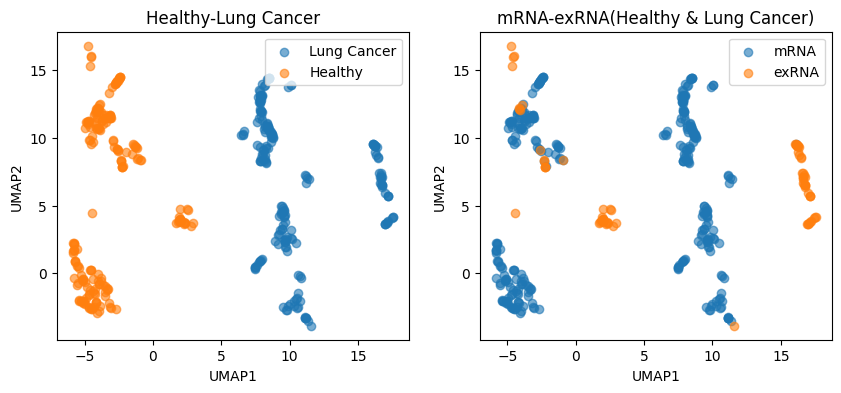

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(121)

iddx = np.where(color_h_c == 0)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='Lung Cancer')

iddx = np.where(color_h_c == 1)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='Healthy')

plt.title('Healthy-Lung Cancer')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()

plt.subplot(122)
iddx = np.where(color_m_ex == 0)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='mRNA')

iddx = np.where(color_m_ex == 1)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='exRNA')

plt.title('mRNA-exRNA(Healthy & Lung Cancer)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()

## KNN

In [24]:
from sklearn.neighbors import NearestNeighbors

knn_m = NearestNeighbors(n_neighbors=10,metric='cosine')
knn_ex = NearestNeighbors(n_neighbors=10,metric='cosine')

knn_m.fit(np.concatenate([y_pred_cm,y_pred_hm]))
knn_ex.fit(np.concatenate([y_pred_cex,y_pred_hex]))

X_knn_m = np.concatenate([X_all_tensor_cm,X_all_tensor_hm])
X_knn_ex = np.concatenate([X_all_tensor_cex,X_all_tensor_hex])

In [25]:
# Cross prediction

eps = 1e-10

def mToEx_multiple(embs):
    dists,idxs = knn_ex.kneighbors(embs)
    dists = dists + eps

    out_ex = np.zeros((len(embs),X_knn_ex.shape[1]))
    for vi in range(len(embs)):
        for i in range(len(dists[vi])):
            out_ex[vi] += (1/dists[vi][i])*X_knn_ex[idxs[vi][i]]
        
        out_ex[vi] = out_ex[vi]/np.sum(1/dists[vi])

    return out_ex

def exToM_multiple(embs):
    dists,idxs = knn_m.kneighbors(embs)
    dists = dists + eps

    out_ex = np.zeros((len(embs),X_knn_m.shape[1]))
    for vi in range(len(embs)):
        for i in range(len(dists[vi])):
            out_ex[vi] += (1/dists[vi][i])*X_knn_m[idxs[vi][i]]
        
        out_ex[vi] = out_ex[vi]/np.sum(1/dists[vi])

    return out_ex

In [26]:
dec_cm = exToM_multiple(y_pred_cex_ts)
dec_hm = exToM_multiple(y_pred_hex_ts)

dec_cex = mToEx_multiple(y_pred_cm_ts)
dec_hex = mToEx_multiple(y_pred_hm_ts)

In [27]:
pred_m = np.concatenate([dec_cm,dec_hm])
true_m = np.concatenate([cancer_mrna_ts,hc_mrna_ts])

pred_ex = np.concatenate([dec_cex,dec_hex])
true_ex = np.concatenate([cancer_exrna_ts,hc_exrna_ts])

### Eval KNN

In [28]:
# Unpaired metric
print("\n\n########## Prediction evaluation ##########\n")

print(stats.pearsonr(np.mean(dec_cm,axis=0),np.mean(cancer_mrna_ts,axis=0)))
print(stats.pearsonr(np.mean(dec_hm,axis=0),np.mean(hc_mrna_ts,axis=0)))
print('Pearson r mRNA (CrossPred):',stats.pearsonr(np.mean(np.concatenate([dec_cm,dec_hm]),axis=0),
                     np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))
print(stats.pearsonr(np.mean(dec_cex,axis=0),np.mean(cancer_exrna_ts,axis=0)))
print(stats.pearsonr(np.mean(dec_hex,axis=0),np.mean(hc_exrna_ts,axis=0)))
print('Pearson r exRNA (CrossPred):',stats.pearsonr(np.mean(np.concatenate([dec_cex,dec_hex]),axis=0),
                     np.mean(np.concatenate([cancer_exrna_ts,hc_exrna_ts]),axis=0)))

#Unpaired Spearman
print(stats.spearmanr(np.mean(dec_cm,axis=0),np.mean(cancer_mrna_ts,axis=0)))
print(stats.spearmanr(np.mean(dec_hm,axis=0),np.mean(hc_mrna_ts,axis=0)))
print('Spearman rank mRNA (CrossPred):',stats.spearmanr(np.mean(np.concatenate([dec_cm,dec_hm]),axis=0),
                     np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))

print(stats.spearmanr(np.mean(dec_cex,axis=0),np.mean(cancer_exrna_ts,axis=0)))
print(stats.spearmanr(np.mean(dec_hex,axis=0),np.mean(hc_exrna_ts,axis=0)))
print('Spearman rank exRNA (CrossPred):',stats.spearmanr(np.mean(np.concatenate([dec_cex,dec_hex]),axis=0),
                     np.mean(np.concatenate([cancer_exrna_ts,hc_exrna_ts]),axis=0)))

print("\n")



########## Prediction evaluation ##########

PearsonRResult(statistic=0.9557802026564929, pvalue=0.0)
PearsonRResult(statistic=0.9156147647027737, pvalue=0.0)
Pearson r mRNA (CrossPred): PearsonRResult(statistic=0.9440305536486429, pvalue=0.0)
PearsonRResult(statistic=0.9649706557074457, pvalue=0.0)
PearsonRResult(statistic=0.9768728071410667, pvalue=0.0)
Pearson r exRNA (CrossPred): PearsonRResult(statistic=0.9854621124115094, pvalue=0.0)
SignificanceResult(statistic=0.9935543767868329, pvalue=0.0)
SignificanceResult(statistic=0.9920179057119451, pvalue=0.0)
Spearman rank mRNA (CrossPred): SignificanceResult(statistic=0.9941533261959016, pvalue=0.0)
SignificanceResult(statistic=0.8429460005904758, pvalue=0.0)
SignificanceResult(statistic=0.8209498437210437, pvalue=0.0)
Spearman rank exRNA (CrossPred): SignificanceResult(statistic=0.8905420848366299, pvalue=0.0)




In [29]:
#Unpaired MAE
from sklearn.metrics import mean_absolute_error

print("MAE Cancer mRNA: ",mean_absolute_error(np.mean(dec_cm,axis=0), np.mean(cancer_mrna_ts,axis=0)))
print("MAE Healthy mRNA: ",mean_absolute_error(np.mean(dec_hm,axis=0),np.mean(hc_mrna_ts,axis=0)))
print("MAE mRNA: ",mean_absolute_error(np.mean(np.concatenate([dec_cm,dec_hm]),axis=0),
                                       np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))
print('\n')
print("MAE Cancer exRNA: ",mean_absolute_error(np.mean(dec_cex,axis=0), np.mean(cancer_exrna_ts,axis=0)))
print("MAE Healthy exRNA: ",mean_absolute_error(np.mean(dec_hex,axis=0),np.mean(hc_exrna_ts,axis=0)))
print("MAE exRNA: ",mean_absolute_error(np.mean(np.concatenate([dec_cex[:,:],dec_hex[:,:]]),axis=0),
                                       np.mean(np.concatenate([cancer_exrna_ts[:,:],hc_exrna_ts[:,:]]),axis=0)))

print("\n\n\n")

MAE Cancer mRNA:  0.6018047418358663
MAE Healthy mRNA:  2.380007505475407
MAE mRNA:  1.3462830265373331


MAE Cancer exRNA:  4.908528526640993
MAE Healthy exRNA:  8.500253772197663
MAE exRNA:  5.478707434771883






### Top mRNAs

In [30]:
## load data
mrna = pd.read_pickle("./bc_data/bc_mrna_data.pkl")
ex = pd.read_pickle("./bc_data/bc_exnonctg.pkl")

In [31]:
mrna = mrna.set_index('gene_name',drop=True)
mrna.index.name = None
mrna = mrna.drop(columns=['gene_id', 'gene_type','length'])
mrna

,1,2,3,4,5,6,7,8,9,10,...,GTEX-ZVTK-0326-SM-51MRR,GTEX-ZVZQ-0826-SM-51MRF,GTEX-ZWKS-2826-SM-5NQ74,GTEX-ZXES-0826-SM-5E43C,GTEX-ZY6K-1626-SM-5GZWV,GTEX-ZYFC-0826-SM-5E44K,GTEX-ZYT6-0126-SM-5E45J,GTEX-ZYW4-0826-SM-5GIDG,GTEX-ZZ64-1226-SM-5E43R,GTEX-ZZPU-0626-SM-5E43T
RPS10,0.097482,0.080485,0.413613,0.143114,0.080869,0.095303,0.067164,0.245950,0.077743,0.302870,...,66.055702,50.980772,58.889057,82.773490,62.420789,56.950599,49.431890,68.822201,46.789728,64.691303
NME2,0.033818,0.008935,0.043201,0.089367,0.101359,0.038572,0.058863,0.130496,0.059334,0.111720,...,37.259113,40.976954,52.532158,40.880600,47.858185,38.877620,23.265971,51.463392,41.555730,39.862233
EIF4A1,0.195303,0.183964,0.086779,0.533558,0.196333,0.237979,0.098534,0.236926,0.503836,0.368685,...,52.986426,60.676103,92.787054,71.240827,117.737441,67.374059,54.590788,143.094917,81.864831,59.213361
RPL17,0.816719,0.264505,0.490409,0.866396,0.501984,0.987346,0.466216,1.751717,0.344581,1.359410,...,187.333394,147.649568,161.078026,258.061433,170.113660,137.448073,139.969025,229.028713,132.904860,178.452478
RPS17,0.297296,0.269303,0.413368,1.662713,0.618285,0.728932,0.353195,1.504380,0.523870,1.362971,...,190.475789,149.941852,155.814462,207.616577,194.944438,139.426231,158.900918,198.218798,153.764574,166.984828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3orf62,1.151743,0.867121,0.581199,1.377689,0.892605,0.911097,0.983846,0.656678,0.969421,1.415057,...,1.421606,1.495482,2.840229,1.389251,1.502113,1.875214,2.409998,0.814873,1.336284,1.359053
SIDT2,2.338367,3.073455,3.237665,4.696538,4.807800,2.936522,2.371405,1.456512,4.781951,4.983064,...,5.214916,4.024075,3.917796,6.537610,5.359920,5.056849,4.691445,7.022839,11.032192,5.147652
PEAK1,0.289547,0.317604,0.032784,0.074501,0.253216,0.278935,0.153207,0.068114,0.242511,0.088495,...,0.212768,0.370732,0.365641,0.243784,0.188702,0.460377,0.383753,0.279676,0.211715,0.299874
KDM7A,0.829199,0.529275,0.272528,0.310814,0.297288,0.370186,0.527989,0.506449,0.420106,0.280406,...,0.614811,0.667406,1.136348,0.974449,0.526139,0.809095,0.818602,0.921436,0.391221,0.912579


/tmp/ipykernel_2078369/1190452096.py:15: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


Text(0.5, 0, 'mRNA value')

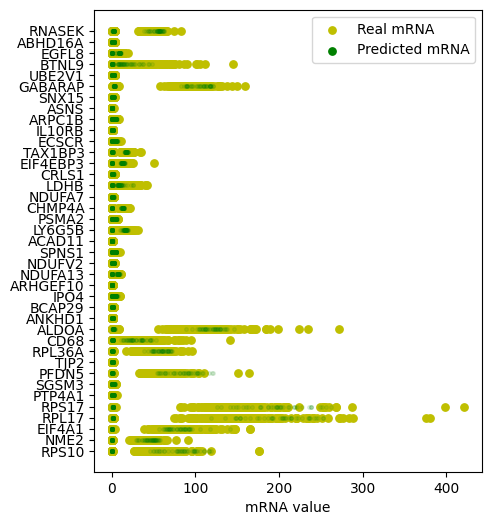

In [32]:
fig = plt.figure(figsize =(5, 6))
gn=39

for i in range(len(mrna.index[:gn])):
#     plt.scatter(pred_m[:,i],y=np.ones(pred_m.shape[0])*(i+1))
#     plt.hlines(y = i+1, xmin=min(true_m[:,i]), xmax=max(true_m[:,i]), color = 'g', linestyle = '-') 
    if i == 0:
        plt.scatter(true_m[:,i],y=np.ones(true_m.shape[0])*(i+1),c='y',s=28,label='Real mRNA')
        plt.scatter(pred_m[:,i],y=np.ones(pred_m.shape[0])*(i+1),alpha=0.1,c='g',s=7, label='Predicted mRNA')
    else:
        plt.scatter(true_m[:,i],y=np.ones(true_m.shape[0])*(i+1),c='y',s=28)
        plt.scatter(pred_m[:,i],y=np.ones(pred_m.shape[0])*(i+1),alpha=0.1,c='g',s=7)
leg = plt.legend()

for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([28])

plt.yticks(np.arange(1,gn+1),mrna.index[:gn])
plt.xlabel('mRNA value')

### Top exRNAs

/tmp/ipykernel_2078369/343962076.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


Text(0.5, 0, 'exRNA value')

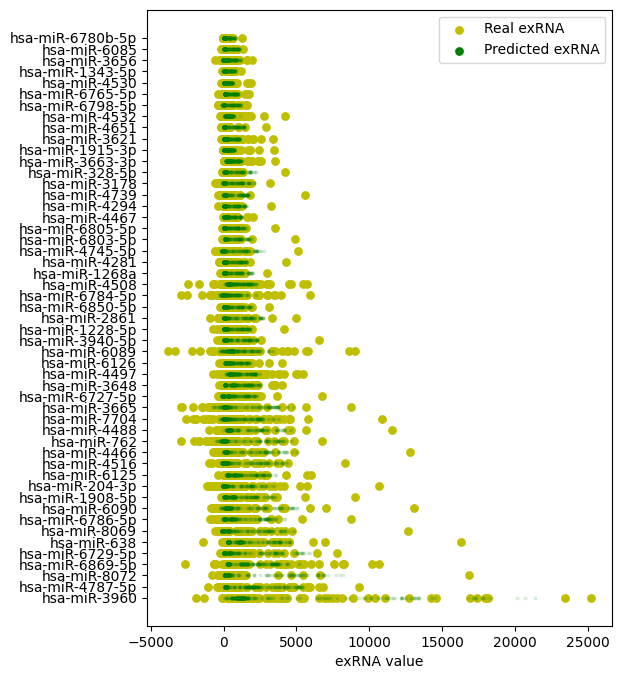

In [33]:
fig = plt.figure(figsize =(6, 8))
gn_ex=51

for i in range(len(ex.index[:gn_ex])):
    if i == 0:
        plt.scatter(true_ex[:,i],y=np.ones(true_ex.shape[0])*(i+1),c='y',s=28, label='Real exRNA')
        plt.scatter(pred_ex[:,i],y=np.ones(pred_ex.shape[0])*(i+1),alpha=0.1,c='g',s=3.5, label = 'Predicted exRNA')
#     plt.hlines(y = i+1, xmin=min(true_ex[:,i]), xmax=max(true_ex[:,i]), color = 'g', linestyle = '-') 
    else:
        plt.scatter(true_ex[:,i],y=np.ones(true_ex.shape[0])*(i+1),c='y',s=28)
        plt.scatter(pred_ex[:,i],y=np.ones(pred_ex.shape[0])*(i+1),alpha=0.1,c='g',s=3.5)

leg = plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([28])
plt.yticks(np.arange(1,gn_ex+1),ex.index[:gn_ex])
plt.xlabel('exRNA value')

### Important exRNA identification

In [34]:
mrna_std=[]
exrna_std = []
for i in range(cancer_mrna_tr.shape[1]):
    mrna_std.append(np.std(np.concatenate([cancer_mrna_tr[:,i],hc_mrna_tr[:,i]])))
for i in range(cancer_exrna_tr.shape[1]):
    exrna_std.append(np.std(np.concatenate([cancer_exrna_tr[:,i],hc_exrna_tr[:,i]])))
    
print(len(mrna_std))
print(len(exrna_std))

1883
2438


In [62]:
print('\n\n########## Calculating important exRNAs. ########## \nThis would take around 4.5Hrs to complete on a standard machine. You can see the progress status below:')
net.eval()
net.to(torch.device("cpu"))

n=50
dist = np.zeros([n,cancer_exrna_ts.shape[1]])

true_val = np.concatenate([dec_cm,dec_hm])

with torch.no_grad():
    for j in tqdm.tqdm(range(n)):
        for i in range(cancer_exrna_ts.shape[1]):

            X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
            X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

            c_ex_noise = np.random.normal(0,exrna_std[i],cancer_exrna_ts.shape[0])
            h_ex_noise = np.random.normal(0,exrna_std[i],hc_exrna_ts.shape[0])

            X_all_tensor_cex_ts[:,i] = X_all_tensor_cex_ts[:,i]+torch.tensor(c_ex_noise*0.01).float()
            X_all_tensor_hex_ts[:,i] = X_all_tensor_hex_ts[:,i]+torch.tensor(h_ex_noise*0.01).float()

            y_pred_cex_ts = net.encoder_b(X_all_tensor_cex_ts)
            y_pred_cex_ts = torch.Tensor.cpu(y_pred_cex_ts).detach().numpy()

            y_pred_hex_ts = net.encoder_b(X_all_tensor_hex_ts)
            y_pred_hex_ts = torch.Tensor.cpu(y_pred_hex_ts).detach().numpy()

            tensor_ex_all = np.concatenate([y_pred_cex_ts,y_pred_hex_ts])
            pred_m_all = exToM_multiple(tensor_ex_all)

            d = np.linalg.norm(pred_m_all - true_val)        

            dist[j,i] = d
            



########## Calculating important exRNAs. ########## 
This would take around 4.5Hrs to complete on a standard machine. You can see the progress status below:


  0%|                                                                                  | 0/50 [00:01<?, ?it/s]


In [36]:
dist_avg = []
for i in range(dist.shape[1]):
    dist_avg.append(np.mean(dist[:,i]))

[  0 817 816 815 814 813 812 811 810 914 808 807 806 805 804 803 802 801
 809 837 836 835 834 833 832 831 830 829 818 827 826 825 824 823 822 821
 820 819 828 780 779 778 777 776 775 774 773 800 771 770 769]


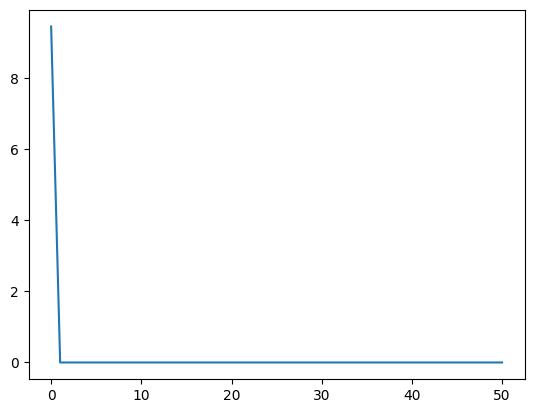

In [37]:
gn_m = 51
plt.plot(dist_avg[:gn_m])
print(np.flip(np.argsort(dist_avg))[:gn_m])
# print(dist)
# print(ex.index[13])

In [38]:
dist_m = np.flip(np.sort(dist_avg))[:gn_m]
print(dist_m[:gn_m])


[9.45864932 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [39]:
ind = np.flip(np.argsort(dist_avg))[:gn_m]
print(ex.index[ind])

Index(['hsa-miR-3960', 'hsa-miR-548ap-5p', 'hsa-miR-7974', 'hsa-miR-551b-3p',
       'hsa-miR-4310', 'hsa-miR-4704-3p', 'hsa-miR-409-3p', 'hsa-miR-4705',
       'hsa-miR-1287-3p', 'hsa-miR-6761-3p', 'hsa-miR-5684', 'hsa-miR-3605-3p',
       'hsa-miR-629-3p', 'hsa-miR-5009-3p', 'hsa-miR-8081', 'hsa-miR-6853-3p',
       'hsa-miR-134-3p', 'hsa-miR-5689', 'hsa-miR-4632-3p', 'hsa-miR-6775-3p',
       'hsa-miR-4733-5p', 'hsa-miR-10a-3p', 'hsa-miR-449b-3p',
       'hsa-miR-4799-5p', 'hsa-miR-196a-3p', 'hsa-miR-4766-3p',
       'hsa-miR-4763-5p', 'hsa-miR-377-5p', 'hsa-miR-518c-5p', 'hsa-miR-4785',
       'hsa-miR-5092', 'hsa-miR-3620-3p', 'hsa-miR-4470', 'hsa-miR-6832-5p',
       'hsa-miR-7160-5p', 'hsa-miR-548f-5p', 'hsa-miR-202-5p',
       'hsa-miR-6512-5p', 'hsa-miR-4796-3p', 'hsa-miR-4419a',
       'hsa-miR-3191-3p', 'hsa-miR-6867-3p', 'hsa-miR-4635', 'hsa-miR-1302',
       'hsa-miR-378d', 'hsa-miR-1266-3p', 'hsa-miR-4703-5p', 'hsa-miR-6733-3p',
       'hsa-miR-4793-5p', 'hsa-miR-16-2-3p'

### Important mRNA identification

In [40]:
print('\n\n########## Calculating important mRNAs. ########## \nThis would take around 4.5Hrs to complete on a standard machine. You can see the progress status below:')
net.eval()
net.to(torch.device("cpu"))

n=50
dist_m = np.zeros([n,cancer_mrna_ts.shape[1]])

true_val_ex = np.concatenate([dec_cex,dec_hex])

with torch.no_grad():
    for j in tqdm.tqdm(range(n)):
        for i in range(cancer_mrna_ts.shape[1]):

            X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
            X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

            c_m_noise = np.random.normal(0,mrna_std[i],cancer_mrna_ts.shape[0])
            h_m_noise = np.random.normal(0,mrna_std[i],hc_mrna_ts.shape[0])

            X_all_tensor_cm_ts[:,i] = X_all_tensor_cm_ts[:,i]+torch.tensor(c_m_noise*0.01).float()
            X_all_tensor_hm_ts[:,i] = X_all_tensor_hm_ts[:,i]+torch.tensor(h_m_noise*0.01).float()

            y_pred_cm_ts = net.encoder_a(X_all_tensor_cm_ts)
            y_pred_cm_ts = torch.Tensor.cpu(y_pred_cm_ts).detach().numpy()

            y_pred_hm_ts = net.encoder_a(X_all_tensor_hm_ts)
            y_pred_hm_ts = torch.Tensor.cpu(y_pred_hm_ts).detach().numpy()

            tensor_m_all = np.concatenate([y_pred_cm_ts,y_pred_hm_ts])
            pred_ex_all = mToEx_multiple(tensor_m_all)

            d = np.linalg.norm(pred_ex_all - true_val_ex)        

            dist_m[j,i] = d
            



########## Calculating important mRNAs. ########## 
This would take around 4.5Hrs to complete on a standard machine. You can see the progress status below:


In [41]:
dist_avg_ex = []
for i in range(dist_m.shape[1]):
    dist_avg_ex.append(np.mean(dist_m[:,i]))
    

[  0 619 620 621 622 623 624 625 626 627 628 629 630 631 647 633 634 635
 636 637 638 639 640 641 642 643 644 645 646 632 590 591 592 593 594 595
 596 597 598]


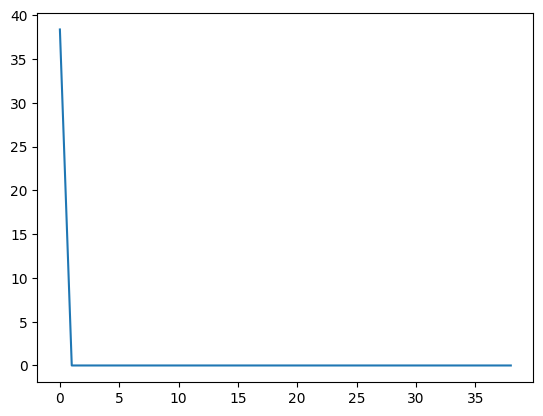

In [42]:
gn_m = 39
plt.plot(dist_avg_ex[:gn_m])
print(np.flip(np.argsort(dist_avg_ex))[:gn_m])

In [43]:
ind_ex = np.flip(np.argsort(dist_avg_ex))[:gn_m]
print(mrna.index[ind_ex])

Index(['RPS10', 'FAM124B', 'NPIPA5', 'VKORC1', 'TNFSF14', 'FZD4', 'PALMD',
       'ACVRL1', 'LMO3', 'MAP7D3', 'HSD17B11', 'KCNB1', 'MFAP4', 'TGFBR3',
       'PALM', 'ESR2', 'RGMA', 'PNISR', 'GALT', 'MYL3', 'TWIST1', 'KLHL41',
       'RUNX1T1', 'JUN', 'APCDD1', 'CAV2', 'RIC3', 'PLCH2', 'DOCK6', 'CLDN11',
       'TACC1', 'SHC3', 'PELI2', 'DDX19A', 'ARPC1A', 'SPARCL1', 'HOXD9',
       'CD209', 'PLSCR4'],
      dtype='object')


### Negative Loglikeluhood mRNA

In [44]:
from typing import Callable
def negative_binom_loss(
    scale_factor: float = 1.0,
    eps: float = 1e-10,
    mean: bool = True,
    debug: bool = False,
#     tb: torch.utils.tensorboard.SummaryWriter = None,
) -> Callable:
    """
    Return a function that calculates the binomial loss
    https://github.com/theislab/dca/blob/master/dca/loss.py

    combination of the Poisson distribution and a gamma distribution is a negative binomial distribution
    """

    def loss(preds, theta, truth, tb_step: int = None):
        """Calculates negative binomial loss as defined in the NB class in link above"""
        y_true = truth
        y_pred = preds * scale_factor
        
        global th_lg
        global ytr_lg
        global ytr_th_lg

        if debug:  # Sanity check before loss calculation
            assert not torch.isnan(y_pred).any(), y_pred
            assert not torch.isinf(y_pred).any(), y_pred
            assert not (y_pred <= 0).any()  # should be non-negative
            assert not (theta <= 0).any()

        # Clip theta values
        theta = torch.clamp(theta, max=1e6)

        t1 = (
            torch.lgamma(theta + eps)
            + torch.lgamma(y_true + 1.0)
            - torch.lgamma(y_true + theta + eps)
        )
        
        th_lg = torch.lgamma(theta + eps).clone()
        ytr_lg = torch.lgamma(y_true + 1.0).clone()
        ytr_th_lg = torch.lgamma(y_true + theta + eps).clone()
        
        
#         print(torch.lgamma(theta + eps),torch.lgamma(y_true + 1.0), torch.lgamma(y_true + theta + eps))
        
        t2 = (theta + y_true) * torch.log1p(y_pred / (theta + eps)) + (
            y_true * (torch.log(theta + eps) - torch.log(y_pred + eps))
        )
        if debug:  # Sanity check after calculating loss
            assert not torch.isnan(t1).any(), t1
            assert not torch.isinf(t1).any(), (t1, torch.sum(torch.isinf(t1)))
            assert not torch.isnan(t2).any(), t2
            assert not torch.isinf(t2).any(), t2

        retval = (t1 + t2)
        if debug:
            assert not torch.isnan(retval).any(), retval
            assert not torch.isinf(retval).any(), retval

#         if tb is not None and tb_step is not None:
#             tb.add_histogram("nb/t1", t1, global_step=tb_step)
#             tb.add_histogram("nb/t2", t2, global_step=tb_step)

        return torch.mean(retval) if mean else retval
    return loss

In [45]:
gn_m=39
X_real_m = torch.concatenate((X_all_tensor_cm_ts[:,:gn_m], X_all_tensor_hm_ts[:,:gn_m]),axis=0)
loss_real = []

for i in range(X_real_m.shape[1]):
    m = torch.mean(X_real_m[:,i])
    v = torch.var(X_real_m[:,i])

    nll = negative_binom_loss()

    loss_real.append(nll(m, v, X_real_m[:,i]))


In [46]:
tensor_pred_cm = torch.tensor(dec_cm).float()
tensor_pred_hm = torch.tensor(dec_hm).float()

X_pred_m = torch.concatenate((tensor_pred_cm[:,:gn_m], tensor_pred_hm[:,:gn_m]),axis=0)
loss_pred = []

for i in range(X_pred_m.shape[1]):
    m = torch.mean(X_pred_m[:,i])
    v = torch.var(X_pred_m[:,i])

    nll = negative_binom_loss()

    loss_pred.append(nll(m, v, X_pred_m[:,i]))


In [47]:
tensor_pred_cm_b = torch.tensor(b_pred_cm_ts[:,:gn_m]).float()
tensor_pred_hm_b = torch.tensor(b_pred_hm_ts[:,:gn_m]).float()

b_pred_m = torch.concatenate((tensor_pred_cm_b,tensor_pred_hm_b),axis=0)
loss_pred_b = []

for i in range(b_pred_m.shape[1]):
    m = torch.mean(b_pred_m[:,i])
    v = torch.var(b_pred_m[:,i])

    nll = negative_binom_loss()

    loss_pred_b.append(nll(m, v, b_pred_m[:,i]))


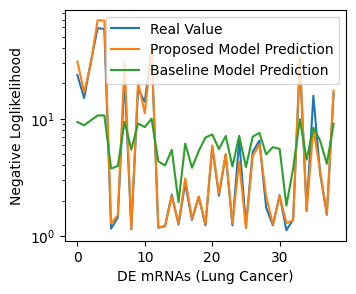

In [48]:
fig = plt.figure(figsize =(8, 3))

plt.subplot(121)
plt.semilogy(loss_real[:gn_m], label='Real Value')
plt.semilogy(loss_pred[:gn_m], label='Proposed Model Prediction')
plt.semilogy(loss_pred_b[:gn_m], label='Baseline Model Prediction')
plt.xlabel("DE mRNAs (Lung Cancer)")
plt.ylabel("Negative Loglikelihood")
plt.legend()


### Negative loglikelihood exRNA graph

In [49]:
gn_ex=51
tensor_pred_cex = torch.tensor(dec_cex).float()
tensor_pred_hex = torch.tensor(dec_hex).float()

X_pred_ex = torch.concatenate((tensor_pred_cex[:,:gn_ex], tensor_pred_hex[:,:gn_ex]),axis=0)

X_real_ex = torch.concatenate((X_all_tensor_cex_ts[:,:gn_ex], X_all_tensor_hex_ts[:,:gn_ex]),axis=0)

b_pred_ex = torch.concatenate((torch.tensor(b_pred_cex_ts[:,:gn_ex]).float(),torch.tensor(b_pred_hex_ts[:,:gn_ex]).float()),
                              axis=0)

m_real = []
s_real = []
m_pred = []
s_pred = []
m_pred_b = []
s_pred_b = []


for i in range(X_real_ex.shape[1]):
    m = torch.mean(X_real_ex[:,i])
    s = torch.std(X_real_ex[:,i])
    
    m_p = torch.mean(X_pred_ex[:,i])
    s_p = torch.std(X_pred_ex[:,i])
    
    m_p_b = torch.mean(b_pred_ex[:,i])
    s_p_b = torch.std(b_pred_ex[:,i])

#     nll = negative_binom_loss()

    m_real.append(m)
    s_real.append(s)
    m_pred.append(m_p)
    s_pred.append(s_p)
    m_pred_b.append(m_p_b)
    s_pred_b.append(s_p_b)


In [50]:
loss = torch.nn.GaussianNLLLoss()
true_loss_ex = []
pred_loss_ex = []
b_pred_loss_ex = []

for i in range(X_real_ex.shape[1]):
    r_real_ex = np.random.normal(m_real[i], s_real[i], X_real_ex.shape[0])
    r_pred_ex = np.random.normal(m_pred[i], s_pred[i], X_pred_ex.shape[0])
    r_pred_ex_b = np.random.normal(m_pred_b[i], s_pred_b[i], b_pred_ex.shape[0])
    
    true_loss_ex.append(loss(X_real_ex[:,i], r_real_ex,s_real[i]**2)) 
#     print(true_loss_ex)
    pred_loss_ex.append(loss(X_pred_ex[:,i], r_pred_ex,s_pred[i]**2))
#     print(pred_loss_ex)
    b_pred_loss_ex.append(loss(b_pred_ex[:,i], r_pred_ex_b,s_pred_b[i]**2))

Text(0, 0.5, 'Negative Loglikelihood')

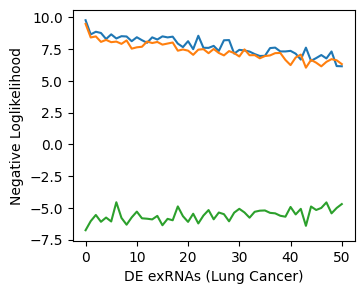

In [51]:
fig = plt.figure(figsize =(8, 3))
gn_ex = 51
plt.subplot(121)
plt.plot(true_loss_ex[:gn_ex], label='Real Value')
plt.plot(pred_loss_ex[:gn_ex], label='Proposed Model Prediction')
plt.plot(b_pred_loss_ex[:gn_ex], label='Baseline Model Prediction')
plt.xlabel("DE exRNAs (Lung Cancer)")
plt.ylabel("Negative Loglikelihood")
# plt.legend()

## Test result for encoders with both exRNA

In [52]:
class CrossPred_exex(torch.nn.Module):
    def __init__(self,input_dim_a=2000,input_dim_b=2000,emb_dim=128):
        super(CrossPred_exex, self).__init__()
        self.input_dim_a = input_dim_a
        self.input_dim_b = input_dim_b
        self.encoder_a = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_a, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        self.encoder_b = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_b, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        
    def forward(self, x_a,x_b):
        out_a = self.encoder_a(x_a)        
        out_b = self.encoder_b(x_b)
        return out_a,out_b


In [53]:
checkpoint_exex = torch.load('./models/bc_model_exex.pt',map_location=torch.device('cpu'))
net_exex = CrossPred_exex(input_dim_a=cancer_exrna_ts.shape[1],input_dim_b=cancer_exrna_ts.shape[1])
net_exex.load_state_dict(checkpoint_exex['model_state_dict'])
net_exex.eval()

CrossPred_exex(
  (encoder_a): Sequential(
    (0): Linear(in_features=2438, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_b): Sequential(
    (0): Linear(in_features=2438, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [54]:
## Integration visualization - test-bothexrna
net_exex.eval()
with torch.no_grad():
    net_exex.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    y_pred_cex2_ts = net_exex.encoder_a(X_all_tensor_cex_ts)
    y_pred_cex2_ts = torch.Tensor.cpu(y_pred_cex2_ts).detach().numpy()

    y_pred_hex2_ts = net_exex.encoder_a(X_all_tensor_hex_ts)
    y_pred_hex2_ts = torch.Tensor.cpu(y_pred_hex2_ts).detach().numpy()

    y_pred_cex1_ts = net_exex.encoder_b(X_all_tensor_cex_ts)
    y_pred_cex1_ts = torch.Tensor.cpu(y_pred_cex1_ts).detach().numpy()

    y_pred_hex1_ts = net_exex.encoder_b(X_all_tensor_hex_ts)
    y_pred_hex1_ts = torch.Tensor.cpu(y_pred_hex1_ts).detach().numpy()

y_pred_exex_ts = np.concatenate((y_pred_cex2_ts, y_pred_hex2_ts, y_pred_cex1_ts, y_pred_hex1_ts),axis=0)

# embedding_exex_ts = umaps_exex.transform(y_pred_exex_ts)

## Test result for encoders with both mRNA

In [55]:
class CrossPred_mm(torch.nn.Module):
    def __init__(self,input_dim_a=2000,input_dim_b=2000,emb_dim=128):
        super(CrossPred_mm, self).__init__()
        self.input_dim_a = input_dim_a
        self.input_dim_b = input_dim_b
#         self.clf_out = clf_out
        self.encoder_a = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_a, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        self.encoder_b = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_b, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        
    def forward(self, x_a,x_b):
        out_a = self.encoder_a(x_a)
        
        out_b = self.encoder_b(x_b)
        return out_a,out_b

In [56]:
checkpoint_mm = torch.load('./models/bc_model_mm.pt',map_location=torch.device('cpu'))
net_mm = CrossPred_mm(input_dim_a=cancer_mrna_ts.shape[1],input_dim_b=cancer_mrna_ts.shape[1])
net_mm.load_state_dict(checkpoint_mm['model_state_dict'])
net_mm.eval()

CrossPred_mm(
  (encoder_a): Sequential(
    (0): Linear(in_features=1883, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_b): Sequential(
    (0): Linear(in_features=1883, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [57]:
##4. Integration visualization - test-bothmrna
net_mm.eval()
with torch.no_grad():
    net_mm.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    y_pred_cm2_ts = net_mm.encoder_a(X_all_tensor_cm_ts)
    y_pred_cm2_ts = torch.Tensor.cpu(y_pred_cm2_ts).detach().numpy()

    y_pred_hm2_ts = net_mm.encoder_a(X_all_tensor_hm_ts)
    y_pred_hm2_ts = torch.Tensor.cpu(y_pred_hm2_ts).detach().numpy()

    y_pred_cm1_ts = net_mm.encoder_b(X_all_tensor_cm_ts)
    y_pred_cm1_ts = torch.Tensor.cpu(y_pred_cm1_ts).detach().numpy()

    y_pred_hm1_ts = net_mm.encoder_b(X_all_tensor_hm_ts)
    y_pred_hm1_ts = torch.Tensor.cpu(y_pred_hm1_ts).detach().numpy()

y_pred_mm_ts = np.concatenate((y_pred_cm2_ts, y_pred_hm2_ts, y_pred_cm1_ts, y_pred_hm1_ts),axis=0)

# embedding_mm_ts = umaps_mm.transform(y_pred_mm_ts)

## Pairwise distance between cancer and healthy samples with different embedding space 

In [58]:
y_pred_all = [[y_pred_cm2_ts,y_pred_cm1_ts,y_pred_hm2_ts,y_pred_hm1_ts],[y_pred_cex2_ts,y_pred_cex1_ts,y_pred_hex2_ts,y_pred_hex1_ts],[y_pred_cm_ts,y_pred_cex_ts,y_pred_hm_ts,y_pred_hex_ts]]#,[umap_mm,umap_xx,umap_mx]]
s = 'y_pred_all_lc = [[y_pred_cm2_ts,y_pred_cm1_ts,y_pred_hm2_ts,y_pred_hm1_ts],[y_pred_cex2_ts,y_pred_cex1_ts,y_pred_hex2_ts,y_pred_hex1_ts],[y_pred_cm_ts,y_pred_cex_ts,y_pred_hm_ts,y_pred_hex_ts]]'

# umap_fits = [y_pred_mm,y_pred_exex,y_pred]
# sumap = 'umap_fits_lc = [y_pred_mm,y_pred_exex,y_pred]'

with open('y_pred_all_bc_test.pkl','wb') as f:
    pickle.dump([y_pred_all,s],f)
    
# with open('y_pred_all_lc_umapfit.pkl','wb') as f:
#     pickle.dump([umap_fits,sumap],f)

In [59]:
with open('./y_pred_all_bc_test.pkl','rb') as f:
    datalist = pickle.load(f)

# with open('./y_pred_all_lc_umapfit.pkl','rb') as f:
#     umapdata = pickle.load(f)

dataType = 'Breast cancer'

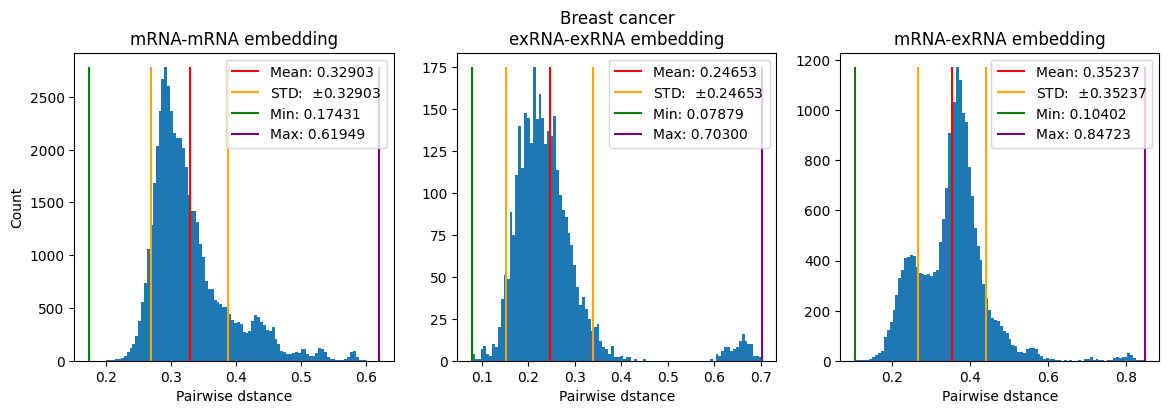

In [60]:
plt.figure(figsize=(14,4))

plt.subplot(131)
dist_mx = cdist(np.concatenate([datalist[0][0][0],datalist[0][0][1]]),np.concatenate([datalist[0][0][2],datalist[0][0][3]]))
dist_mx_v = dist_mx[np.tril_indices_from(dist_mx,k=-1)]

hg,_,_ = plt.hist(dist_mx_v,bins=100)
plt.xlabel('Pairwise dstance')
mvv = np.mean(dist_mx_v)
plt.vlines(mvv,0,np.max(hg),'r',label='Mean: {:.5f}'.format(np.mean(mvv)))
plt.vlines([mvv - np.std(dist_mx_v),mvv + np.std(dist_mx_v)],0,np.max(hg),'orange',label='STD: '+r' $\pm$'+'{:.5f}'.format(np.mean(dist_mx_v)))
plt.vlines(np.min(dist_mx_v),0,np.max(hg),'g',label='Min: {:.5f}'.format(np.min(dist_mx_v)))
plt.vlines(np.max(dist_mx_v),0,np.max(hg),'purple',label='Max: {:.5f}'.format(np.max(dist_mx_v)))

plt.title('mRNA-mRNA embedding')
plt.ylabel('Count')

plt.legend()


plt.subplot(132)
dist_mx = cdist(np.concatenate([datalist[0][1][0],datalist[0][1][1]]),np.concatenate([datalist[0][1][2],datalist[0][1][3]]))
dist_mx_v = dist_mx[np.tril_indices_from(dist_mx,k=-1)]

hg,_,_ = plt.hist(dist_mx_v,bins=100)
plt.xlabel('Pairwise dstance')
mvv = np.mean(dist_mx_v)
plt.vlines(mvv,0,np.max(hg),'r',label='Mean: {:.5f}'.format(np.mean(mvv)))
plt.vlines([mvv - np.std(dist_mx_v),mvv + np.std(dist_mx_v)],0,np.max(hg),'orange',label='STD: '+r' $\pm$'+'{:.5f}'.format(np.mean(dist_mx_v)))
plt.vlines(np.min(dist_mx_v),0,np.max(hg),'g',label='Min: {:.5f}'.format(np.min(dist_mx_v)))
plt.vlines(np.max(dist_mx_v),0,np.max(hg),'purple',label='Max: {:.5f}'.format(np.max(dist_mx_v)))

plt.title('{}\nexRNA-exRNA embedding'.format(dataType))
# plt.ylabel('Count')

plt.legend()


plt.subplot(133)
dist_mx = cdist(np.concatenate([datalist[0][2][0],datalist[0][2][1]]),np.concatenate([datalist[0][2][2],datalist[0][2][3]]))
dist_mx_v = dist_mx[np.tril_indices_from(dist_mx,k=-1)]

hg,_,_ = plt.hist(dist_mx_v,bins=100)
plt.xlabel('Pairwise dstance')
mvv = np.mean(dist_mx_v)
plt.vlines(mvv,0,np.max(hg),'r',label='Mean: {:.5f}'.format(np.mean(mvv)))
plt.vlines([mvv - np.std(dist_mx_v),mvv + np.std(dist_mx_v)],0,np.max(hg),'orange',label='STD: '+r' $\pm$'+'{:.5f}'.format(np.mean(dist_mx_v)))
plt.vlines(np.min(dist_mx_v),0,np.max(hg),'g',label='Min: {:.5f}'.format(np.min(dist_mx_v)))
plt.vlines(np.max(dist_mx_v),0,np.max(hg),'purple',label='Max: {:.5f}'.format(np.max(dist_mx_v)))

plt.title('mRNA-exRNA embedding')
# plt.ylabel('Count')

plt.legend()